In [1]:
# Example python program to read data from a PostgreSQL table

# and load into a pandas DataFrame

import psycopg2

import pandas as pd

import re

from sqlalchemy import create_engine

In [2]:
dbUser = "postgres"
dbPassword = "postgres"
dbHostname = "localhost"
dbPort = 5432
dbName = "tinkoff"

connectionString = "postgresql://%s:%s@%s:%d/%s?sslmode=disable" % (dbUser, dbPassword, dbHostname, dbPort, dbName)
# Create an engine instance
alchemyEngine = create_engine(connectionString, pool_recycle=3600);

In [3]:
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("""
SELECT name, instrument.id, figi, ts, open_price, close_price, high_price, low_price, volume
FROM candle
LEFT JOIN instrument
 ON candle.instrument_id=instrument.id""", dbConnection);

pd.set_option('display.expand_frame_repr', False);

# Close the database connectio
dbConnection.close();

# Drop duplicates
df = df.drop_duplicates()

# Print the DataFrame
df.shape

(1252689, 9)

## Generate parquet

In [4]:
df.to_parquet("data.parquet", compression='gzip')

## Load parquet

In [38]:
df = pd.read_parquet("data.parquet")

In [39]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:30:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.23,114.41,114.16,138376.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:30:00+00:00,114.33,114.32,114.37,114.25,56589.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:15:00+00:00,114.18,114.33,114.34,114.16,68477.0


## Limit instruments count

In [25]:
df = df[df["id"] < 50]

In [40]:
instruments_count = df["id"].unique().size

## Preprocess data

In [41]:
metric_names = ['open_price','close_price','high_price','low_price','volume']

df_data_set = pd.DataFrame()

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute

# Add target column
target_name = 'open_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

# Create non time columns list
data_columns_list = [x for x in df_data_set.columns if re.match('.*_\d+', x) is not None]

# Calc percentage
# df_data_set[data_columns_list] /= df_data_set[data_columns_list].iloc[0]
# Calc derivative for each column
# df_data_set[data_columns_list] = df_data_set[data_columns_list].diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

# # Normalize data
# column_normalizer = {'year':3000, 'month':12, 'day':31, 'weekday':7, 'hour':24, 'minute':60}
# for column_name, normalizer_val in column_normalizer.items():
#     df_data_set[column_name] /= normalizer_val

# # Calc percentage
# # df_data_set /= df_data_set.iloc[0]
# # Calc derivative for each column
# df_data_set = df_data_set.diff()
# # Fill first row with zeros
# df_data_set = df_data_set.fillna(0)

print(df_data_set.shape)
df_data_set.describe()

(1404, 2298)


,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,open_price_7,open_price_8,open_price_10,open_price_11,...,target_487,target_490,target_492,target_493,target_495,target_500,target_508,target_510,target_516,target_517
count,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,...,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000
mean,115.025840,217.015869,30.422030,55.808399,33.507892,54.571047,72.023647,54.190157,1960.292080,266.054836,...,6.281667,104.929929,48.148903,22.046439,133.286382,12.442856,101.480527,868.581197,22.533611,29.174145
std,1.677002,2.305847,0.484189,0.993589,0.508320,1.635100,1.585888,0.575461,35.141565,3.032906,...,0.516407,2.262780,1.363411,1.216038,2.630454,0.384062,1.943807,49.173104,0.652696,1.028331
min,112.580000,212.550000,29.300000,53.940000,32.050000,51.940000,68.980000,52.990000,1867.280000,257.670000,...,5.210000,100.300000,46.170000,20.110000,127.530000,11.380000,97.420000,788.000000,21.520000,26.530000
25%,113.827500,215.160000,30.140000,55.009375,33.420000,53.187500,70.650000,53.707500,1935.392500,264.000000,...,5.777500,102.880000,46.920000,20.840000,131.187500,12.220000,99.850000,816.000000,21.940000,28.450000
50%,114.450000,216.470000,30.400000,55.666250,33.590000,54.480000,72.100000,54.235000,1960.255000,265.680000,...,6.400000,105.590000,47.745000,21.870000,133.615000,12.520000,101.735000,886.000000,22.500000,29.520000
75%,116.282500,218.490000,30.820000,56.538125,33.880000,55.450000,73.382500,54.650000,1989.470000,268.125000,...,6.580000,106.410000,48.712500,23.300000,135.640000,12.710000,103.160000,910.000000,23.100000,30.020000
max,119.340000,223.000000,31.360000,58.337500,34.390000,57.930000,75.060000,55.390000,2029.670000,273.860000,...,7.270000,109.540000,51.530000,24.180000,139.470000,13.290000,104.840000,958.000000,24.100000,30.940000


<AxesSubplot:xlabel='ts'>

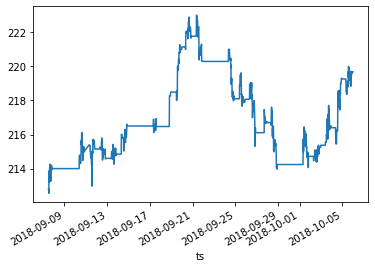

In [42]:
df_data_set.iloc[:,1].plot()

# Neural network

In [43]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4795055495701525560
]


In [46]:
y_size = instruments_count
X_size = df_data_set.shape[1] - y_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# scale inputs with MinMaxScaler()
input_scaler =  MinMaxScaler()
# fit scaler
input_scaler.fit(X_train)
# transform training dataset
X_train = input_scaler.transform(X_train)
# transform test dataset
X_test = input_scaler.transform(X_test)

# Transform output with MinMaxScaler()
output_scaler = MinMaxScaler()
# fit scaler on training dataset
output_scaler.fit(y_train)
# transform training dataset
y_train = output_scaler.transform(y_train)
# transform test dataset
y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 100

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
# foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1023, 101, 1916)
(1023, 382)
(181, 101, 1916)
(181, 382)


In [36]:
#Build the model
layer_size = 100

model = keras.Sequential()
model.add(layers.LSTM(units=layer_size,return_sequences=True,input_shape=(look_back + 1,X_size)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=y_size))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

print(model.summary())

# Create early stop
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
# fit model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    batch_size=50,
                    verbose=2,
                    callbacks=[es])

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squard error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 101, 5)            4240      
_________________________________________________________________
dropout_28 (Dropout)         (None, 101, 5)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 101, 5)            220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 101, 5)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 101, 5)            220       
_________________________________________________________________
dropout_30 (Dropout)         (None, 101, 5)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 5)                 220       
__________

KeyboardInterrupt: 

# Prediction

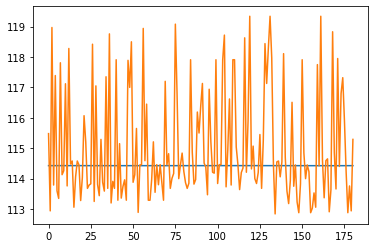

In [37]:
y_pred_test = model.predict(X_test)

plt.plot(output_scaler.inverse_transform(y_pred_test)[:,0])
plt.plot(output_scaler.inverse_transform(y_test)[:,0])
# plt.plot(y_pred_test[:,0])
# plt.plot(y_test.iloc[:,0].values)